In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math as mt
import random as rand
from mpl_toolkits.mplot3d import axes3d


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

ro.numpy2ri.activate()
pandas2ri.activate()

In [8]:
parser = lambda date: pd.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv("sorted.csv", nrows=200000, parse_dates=[1], date_parser=parser, index_col=0)


In [9]:
def findDateIndex(date):
    # start date of first full day of observations in the data
    start_date = dt.date(2006, 12, 17)
    #how many days have passed between start date and input date
    days = (date - start_date).days

    # return the index: 60 obs/minute; 1440 obs/day
    # we return the csv row where our input date occurs
    return days*1440

In [10]:
def getRefWindow(num, wintype, date):
    idx = findDateIndex(date)

    #create empty data frames
    rf = pd.DataFrame([])
    tf = pd.DataFrame([])

    #now jump back (wintype = 7 for day_period, day, or week), and copy slices into our new DataFrame
    idx = idx - (num*1440*wintype)

    # add reference windows to dataframe
    for i in range(0,num):
      # I think the 1:2 is the global active power column
      rf = rf.append(data.iloc[idx+day_start:idx+day_end, 1:2])

      #output to csv for testing.
      temp = data.iloc[idx+day_start:idx+day_end, 1:2]
      temp.to_csv('ref' + str(i) + '.csv', header=False, index=False)

      # advance through the days and append
      idx = idx + (1440*wintype)

    # get test window
    tf = tf.append(data.iloc[idx+day_start:idx+day_end, 1:2])
    # output to csv
    tf.to_csv('testwin.csv', header=False, index=False)

    return rf.as_matrix(), tf

In [11]:
rstring="""
        function(){

            library("mhsmm")

            # grab the training window data
            data1 = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/ref0.csv"))
            data1 = as.numeric(data1)
            data1List = list(x=data1, N=length(data1))

            data2 = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/ref1.csv"))
            data2 = as.numeric(data2)
            data2List = list(x=data2, N=length(data2))

            data3 = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/ref2.csv"))
            data3 = as.numeric(data3)
            data3List = list(x=data3, N=length(data3))


            train = list(x=c(data1,data2,data3), N=c(length(data1),length(data2),length(data2)))
            class(train) <- "hsmm.data"

            # grab the testing window data
            
            dataT = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/testwin.csv"))
            dataT = as.numeric(dataT)
            test = list(x=dataT, N=length(dataT))
            class(test) <- "hsmm.data"


            # initialize values for learning the HSMM

            J <- 4
            M = 150

            d <- cbind(dunif(1:M,0,150),
                       dunif(1:M,0,150),
                       dunif(1:M,0,150),
                       dunif(1:M,0,150))

            start.np <- hsmmspec(init=rep(1/J,J),
                                 transition=matrix(c(.00,.5,.5,.5,
                                                     .5,.00,.5,.5,
                                                     .5,.50,.00,.50,
                                                     .5,.50,.50,.00),nrow=J),
                                 parms.emission=list(mu=c(0.5, 1.5, 2.5, 3.5),
                                                     sigma=c(0.75, 0.5, 0.5, 0.5)),
                                 sojourn=list(d=d,type='nonparametric'),
                                 dens.emission=dnorm.hsmm)

            #fit the model
            h.act <- hsmmfit(train,start.np,mstep=mstep.norm,M=M,graphical=FALSE)
            
            # predict on test window
            p_test <- predict(h.act,test)
            
            #predict each reference window
            p_ref0 <- predict(h.act,data1)
            p_ref1 <- predict(h.act,data2)
            p_ref2 <- predict(h.act,data3)

            # get absolute value of the difference of results
            
            output <- list(t1 = p_test$s, r0 = p_ref0$s, r1 = p_ref1$s, r2 = p_ref2$s) 
            
            output
           
        }
    """

In [12]:
test_date = dt.date(2007, 2, 28)

num_ref = 3
win_type = 7
day_start = 420
#1900
day_end = 1140

length = day_end - day_start

rw,tw = getRefWindow(num_ref, win_type, test_date)

In [13]:
rfunc=ro.r(rstring)
    # call the function in R and return the log likelyhood
predict=rfunc()

/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: mvtnorm

  warnings.warn(x, RRuntimeWarning)


[1]
 2.795626e-09
 5.641892e-01


[1]
 4.326851e-29
 9.349504e-01


[1]
 2.555329e-47
 1.194199e+00


[1]
 1.123443e-66
 1.415784e+00


[1]
 3.467514e-74
 1.492443e+00


[1]
 3.929869e-78
 1.531044e+00


[1]
 9.704918e-85
 1.593226e+00


[1]
 1.624324e-91
 1.654308e+00


[1]
 2.024264e-97
 1.791244e+00


[1]
 7.964396e-107
  1.934541e+00


[1]
 2.465265e-112
  2.031960e+00


[1]
 5.455481e-113
  2.091998e+00


[1]
 2.479120e-113
  2.142498e+00


[1]
 4.082517e-114
  2.184091e+00


[1]
 3.967568e-114
  2.212361e+00


[1]
 7.306861e-114
  2.228906e+00


[1]
 1.274598e-113
  2.239211e+00


[1]
 1.894647e-113
  2.247716e+00


[1]
 2.585332e-113
  2.256962e+00


[1]
 1.778288e-113
  2.268898e+00


[1]
 4.456670e-115
  2.284222e+00


[1]
 7.163286e-117
  2.301606e+00


[1]
 7.698427e-119
  2.320667e+00


[1]
 5.356965e-121
  2.341561e+00


[1]
 5.55943e-123
  2.36083e+00


[1]
 1.834307e-124
  2.375200e+00


[1]
 2.584735e-125
  2.383406e+00


[1]
 9.738623e-126
  2.387465e+00


[1]
 5.89405

In [14]:
seq = np.asarray(predict)

In [15]:
test1 = abs(seq[0] - seq[1]) # test vs ref0
test2 = abs(seq[0] - seq[2]) # test vs ref1
test3 = abs(seq[0] - seq[3]) # test vs ref2

In [16]:
tw = pd.read_csv("testwin.csv", header=None)
ref0 = pd.read_csv("ref0.csv", header=None)
ref1 = pd.read_csv("ref1.csv", header=None)
ref2 = pd.read_csv("ref2.csv", header=None)

tw = tw.as_matrix().reshape((tw.shape[0],))
ref0 = ref0.as_matrix().reshape((ref0.shape[0],))
ref1 = ref1.as_matrix().reshape((ref1.shape[0],))
ref2 = ref2.as_matrix().reshape((ref2.shape[0],))


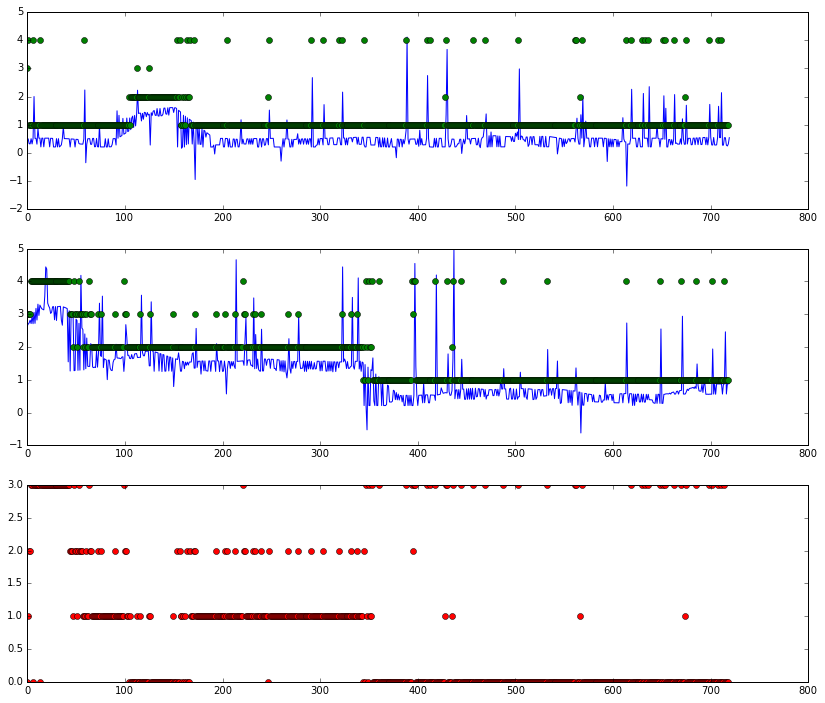

In [17]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(seq[0], 'go')
plt.subplot(312)
plt.plot(ref0)
plt.plot(seq[1], 'go')
plt.subplot(313)
plt.plot(test1, 'ro')
plt.show()

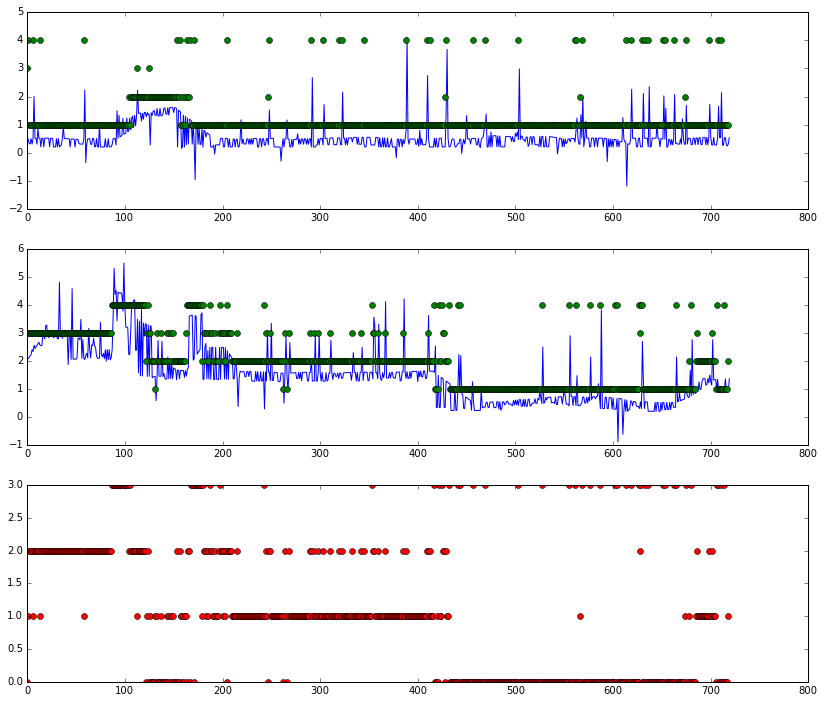

In [18]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(seq[0], 'go')
plt.subplot(312)
plt.plot(ref1)
plt.plot(seq[2], 'go')
plt.subplot(313)
plt.plot(test2, 'ro')
plt.show()

In [19]:
seqsum = seq[0] + seq[1] + seq[2]

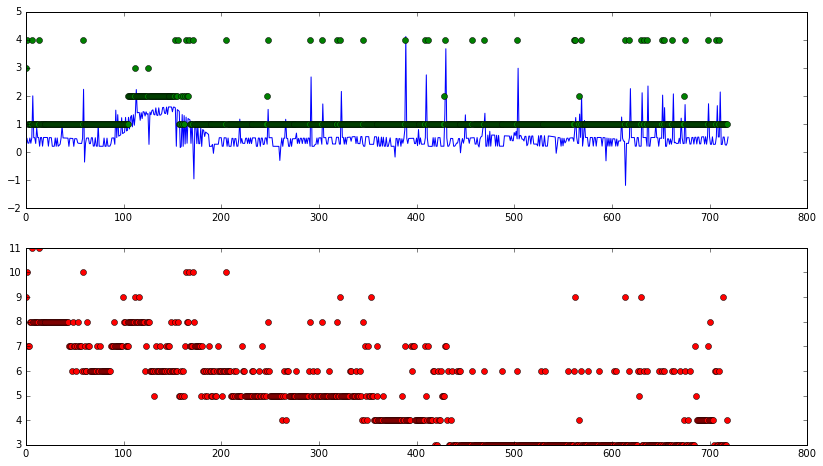

In [20]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(seq[0], 'go')
plt.subplot(312)
plt.plot(seqsum, 'ro')
plt.show()

In [36]:
#max/min length -- these need to have (max-min) >= 2 for a single window
max_length = 20
min_length = 5

# density threshold
dt = 5
# initial window size
k = max_length
#max number of scores
score_max = 5
#number of window sizes
w = int(mt.floor(mt.log((max_length-min_length), 2)))

In [37]:
# x = np.arange(w)
# y = np.arange(len)
# X, Y = np.meshgrid(x,y)
# Z = np.zeros((y.shape[0], x.shape[0]))

X = np.zeros(w*length)
Y = np.zeros(w*length)
Z = np.zeros(w*length)

for i in range(w):
  X[i*length:i*length+length] = i+1
  Y[i*length:i*length+length] = np.arange(length)

dx = np.ones(w*length)
dy = np.ones(w*length)
dz = np.zeros(w*length)

In [38]:
for i in range(0,w):

    # reset number of scores for this window size
    score_count = 0
    #slide the window over everything, take scores over the threshold
    for j in range(0,seqsum.shape[0] - (k-1)):

      s = float(np.sum(seqsum[j:j+k]))

      d = float(s / k)
     
        
      #print(arr[j:j+k], " ", d, d>dt, " ", ((j+k+j)/2))
      if ((d > dt)):
          Z[i*length+int((j+k+j)/2)] += d
          #print(Z[int((j+k+j)/2),i], " ", d, " ", j, " ", j+k, " ", int((j+k+j)/2))
          score_count += 1

    # cut the window size in half
    k = int(mt.floor(k / 2))



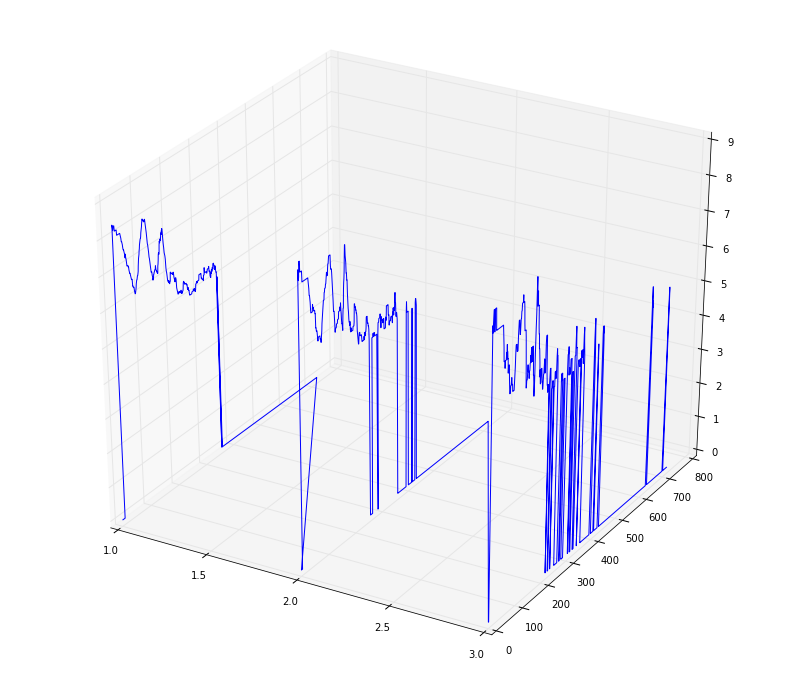

In [39]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(X, Y, Z)
plt.show() 